## **Neural Collaborative Filtering**

# Homework 3

I copied the notebook that Asi gave us and added the answers at the end of this file, right after the title: **my homework**

====================================================================================

This notebook is based on the implementation by the author of the "Neural Collaborative Filtering" paper. [Link](https://github.com/hexiangnan/neural_collaborative_filtering
) 

Neural Collaborative Filtering
This is our implementation for the paper:

Xiangnan He, Lizi Liao, Hanwang Zhang, Liqiang Nie, Xia Hu and Tat-Seng Chua (2017). Neural Collaborative Filtering. In Proceedings of WWW '17, Perth, Australia, April 03-07, 2017.

Three collaborative filtering models: Generalized Matrix Factorization (GMF), Multi-Layer Perceptron (MLP), and Neural Matrix Factorization (NeuMF). To target the models for implicit feedback and ranking task, we optimize them using log loss with negative sampling.

Please cite our WWW'17 paper if you use our codes. Thanks!

Author: Dr. Xiangnan He (http://www.comp.nus.edu.sg/~xiangnan/)[link text](https://)

In [10]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [11]:
!ls '/content/gdrive/MyDrive/idc_rs'

ml-1m.test.negative  ml-1m.test.rating	ml-1m.train.rating


In [1]:
'''
Created on Aug 9, 2016
Updated on May 20, 2018

Keras Implementation of Generalized Matrix Factorization (GMF) recommender model in:
He Xiangnan et al. Neural Collaborative Filtering. In WWW 2017.  

@original author: Xiangnan He (xiangnanhe@gmail.com)
@Updated and placed on notebooks: Guy Shtar (shtar@post.bgu.ac.il)
'''

import numpy as np
import tensorflow as T
from tensorflow import keras
from keras import backend as K
from keras import initializers
from keras.initializers import RandomNormal
from keras.models import Sequential, Model, load_model, save_model
from keras.layers.core import Dense, Lambda, Activation
from keras.layers import Embedding, Input, Dense, Reshape,  Flatten, Dropout
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
from keras.regularizers import l2
from keras.layers import Multiply, Concatenate
from time import time
import multiprocessing as mp
import sys
import math
import argparse
import pandas as pd 
import matplotlib.pyplot as plt 

ModuleNotFoundError: No module named 'keras'

Dataset handling

In [13]:
import scipy.sparse as sp
import numpy as np

class Dataset(object):
    '''
    classdocs
    '''

    def __init__(self, path):
        '''
        Constructor
        '''
        self.trainMatrix = self.load_rating_file_as_matrix(path + ".train.rating")
        self.testRatings = self.load_rating_file_as_list(path + ".test.rating")
        self.testNegatives = self.load_negative_file(path + ".test.negative")
        assert len(self.testRatings) == len(self.testNegatives)
        
        self.num_users, self.num_items = self.trainMatrix.shape
        
    def load_rating_file_as_list(self, filename):
        ratingList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                ratingList.append([user, item])
                line = f.readline()
        return ratingList
    
    def load_negative_file(self, filename):
        negativeList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                negatives = []
                for x in arr[1: ]:
                    negatives.append(int(x))
                negativeList.append(negatives)
                line = f.readline()
        return negativeList
    
    def load_rating_file_as_matrix(self, filename):
        '''
        Read .rating file and Return dok matrix.
        The first line of .rating file is: num_users\t num_items
        '''
        # Get number of users and items
        num_users, num_items = 0, 0
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                u, i = int(arr[0]), int(arr[1])
                num_users = max(num_users, u)
                num_items = max(num_items, i)
                line = f.readline()
        # Construct matrix
        mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mat[user, item] = 1.0
                line = f.readline()    
        return mat

Model Evaluation

In [14]:
import math
import heapq # for retrieval topK
import multiprocessing
import numpy as np
from time import time
#from numba import jit, autojit

# Global variables that are shared across processes
_model = None
_testRatings = None
_testNegatives = None
_K = None

def evaluate_model(model, testRatings, testNegatives, K, num_thread):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    global _model
    global _testRatings
    global _testNegatives
    global _K
    _model = model
    _testRatings = testRatings
    _testNegatives = testNegatives
    _K = K
        
    hits, ndcgs, mrrs_5, mrrs_10 = [],[],[],[] 
    for idx in range(len(_testRatings)):
        (hr,ndcg, mrr_5, mrr_10) = eval_one_rating(idx)
        hits.append(hr)
        ndcgs.append(ndcg) 
        mrrs_5.append(mrr_5)
        mrrs_10.append(mrr_10)     
    return (hits, ndcgs, mrrs_5, mrrs_10)

def eval_one_rating(idx):
    rating = _testRatings[idx]
    items = _testNegatives[idx]
    u = rating[0]
    gtItem = rating[1]
    items.append(gtItem)
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), u, dtype = 'int32')
    predictions = _model.predict([users, np.array(items)], 
                                 batch_size=100, verbose=0)
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    items.pop()
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(_K, map_item_score, key=map_item_score.get)
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    mrr_5 = getMRR(ranklist, gtItem, 5)
    mrr_10 = getMRR(ranklist, gtItem, 10)
    return (hr, ndcg, mrr_5, mrr_10)

def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

def getMRR(ranklist, gtItem, mrr_len):
    rank_len = min(mrr_len, len(ranklist))
    for i in range(rank_len):
        item = ranklist[i]
        if item == gtItem:
            return 1 / (i + 1)
    return 0

You can download the dataset from the author's github or from my drive:

[ml-1m.test.negative](https://https://drive.google.com/file/d/1v3XEN7pjtsjzxx5fuioNbIzMOyom1nNn/view?usp=sharing)

[ml-1m.test.rating](https://drive.google.com/file/d/1TldYS-vtNVAFPXvDTYuuhi3cky37yXK0/view?usp=sharing)

[ml-1m.train.rating](https://https://drive.google.com/file/d/1rFxJ8rG9LVczeCmKC7AXo2Y6sFXo7maG/view?usp=sharing)

In [15]:
!ls '/content/gdrive/MyDrive/'

 201639663_2018_06.pdf
 201639663_2019_08.pdf
'27-7 recommendations.gsheet'
'agent cleanup.gdoc'
 agent_statistics_2018-10-06-14-36.gsheet
 agent_statistics_2018-10-06-14-39.gsheet
 agent_statistics_2018-10-10-06-50.gsheet
 agent_statistics_2018-10-10-06-54.gsheet
 agent_statistics_2018-10-10-06-56.gsheet
 agent-statistics.csv
 agent-statistics.gsheet
 ALL_PARCELS
'alon copy robin buyers preferences editor.gsheet'
'alon&gal'
 alons_permists.gsheet
 alteranteList3.gsheet
 alternate_13_07_2019.gsheet
 alternate4.gsheet
 alternate5.gsheet
 alternate_final_05_07_2018.gsheet
 alternate_final.gsheet
'application server user prefernce deployment .gdoc'
'Application team.gslides'
'APP SLIDES.gslides'
'Apps next steps .gdoc'
'Backend Engineer - Madlan.gdoc'
 bad_source_area_ids.csv
 bad_source_area_ids.csv.gsheet
 bad_target_area_ids_final.csv
 bad_target_area_ids_final.csv.gsheet
 bayesian_mechanic_data.gsheet
'BEBE learning'
 bulletin_images
 bulletins-fetcher-extension.zip
'bulletins statics

In [16]:
# Loading data
path='/content/gdrive/MyDrive/idc_rs/'
dataset='ml-1m'
#dataset='pinterest-20'
t1 = time()
dataset = Dataset(path + dataset)
train, testRatings, testNegatives = dataset.trainMatrix, dataset.testRatings, dataset.testNegatives
num_users, num_items = train.shape
print("Load data done [%.1f s]. #user=%d, #item=%d, #train=%d, #test=%d" 
      %(time()-t1, num_users, num_items, train.nnz, len(testRatings)))

Load data done [20.7 s]. #user=6040, #item=3706, #train=994169, #test=6040


In [17]:
num_users

6040

In [18]:
type(train)

scipy.sparse.dok.dok_matrix

Add Negative Sampling to Train Data

In [19]:
def get_train_instances(train, num_negatives):
    user_input, item_input, labels = [],[],[]
    num_users = train.shape[0]
    for (u, i) in train.keys():
        # positive instance
        user_input.append(u)
        item_input.append(i)
        labels.append(1)
        # negative instances
        for t in range(num_negatives):
            j = np.random.randint(num_items)
            while (u, j) in train:
                j = np.random.randint(num_items)
            user_input.append(u)
            item_input.append(j)
            labels.append(0)
    return user_input, item_input, labels

Define three models: GMF, MLP and NMF

In [115]:
def get_GMF_model(num_users, num_items, latent_dim, regs=[[0,0]]):
    #Generalized Matrix Factorization
    
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                   embeddings_regularizer = l2(regs[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                   embeddings_regularizer = l2(regs[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))  #init = init_normal, 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent]) #merge([user_latent, item_latent], mode = 'mul')
    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(predict_vector)
    
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
    return model


def get_MLP_model(num_users, num_items, latent_dim, regs=[[0,0],0,0], layers = [20,10]):
    #Multi-Layer Perceptron
    
    assert len(layers) + 1 == len(regs), 'the number of regs is equal to number of layers + the embedding layer'
    num_layer = len(layers) #Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding',
                                   embeddings_regularizer = l2(regs[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding',
                                   embeddings_regularizer = l2(regs[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))
    
    # Concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])#merge([user_latent, item_latent], mode = 'concat')
    
    # MLP layers
    for idx in range(num_layer):
        layer = Dense(layers[idx], kernel_regularizer = l2(regs[idx+1]), activation='relu', name = 'layer%d' %idx)
        vector = layer(vector)
        
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = 'prediction')(vector)
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
    return model

def get_NMF_model(num_users, num_items, latent_dim_GMF, latent_dim_MLP, reg_GMF=[[0,0]], regs_MLP=[[0,0],0,0], layers=[20,10]):
    #Neural matrix factorization
    assert len(layers) + 1 == len(regs_MLP), 'the number of regs is equal to number of layers + the embedding layer'
    num_layer = len(layers) #Number of layers in the MLP

    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
    # Embedding layer
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim_GMF, name = 'MF_user_embedding',
                                   embeddings_regularizer = l2(reg_GMF[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim_GMF, name = 'MF_item_embedding',
                                   embeddings_regularizer = l2(reg_GMF[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))  #init = init_normal, 
    
    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim_MLP, name = 'MLP_user_embedding',
                                   embeddings_regularizer = l2(regs_MLP[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim_MLP, name = 'MLP_item_embedding',
                                   embeddings_regularizer = l2(regs_MLP[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent]) #merge([mf_user_latent, mf_item_latent], mode = 'mul') # element-wise multiply

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])#merge([mlp_user_latent, mlp_item_latent], mode = 'concat')
    for idx in range(num_layer):
        layer =  Dense(layers[idx], kernel_regularizer = l2(regs_MLP[idx+1]), activation='tanh', name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform', name = "prediction")(predict_vector)    
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
    return model

def get_MF_model(num_users, num_items, latent_dim):
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')

    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim, name = 'user_embedding', input_length=1)
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim, name = 'item_embedding', input_length=1)   
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))
    
    # Element-wise product of user and item embeddings
    #prediction = merge([user_latent, item_latent], mode = 'dot')
    prediction = keras.layers.dot([user_latent,item_latent], axes=1,normalize=False)
    
    
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')
    return model

def get_NMF_model_question3(num_users, num_items, latent_dim_GMF, latent_dim_MLP, reg_GMF=[[0,0]], regs_MLP=[[0,0],0,0], layers=[20,10]):
    #Neural matrix factorization
    assert len(layers) + 1 == len(regs_MLP), 'the number of regs is equal to number of layers + the embedding layer'
    num_layer = len(layers) #Number of layers in the MLP

    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name = 'user_input')
    item_input = Input(shape=(1,), dtype='int32', name = 'item_input')
    
    # Embedding layer
    MF_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim_GMF, name = 'MF_user_embedding',
                                   embeddings_regularizer = l2(reg_GMF[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MF_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim_GMF, name = 'MF_item_embedding',
                                   embeddings_regularizer = l2(reg_GMF[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01))  #init = init_normal, 
    
    MLP_Embedding_User = Embedding(input_dim = num_users, output_dim = latent_dim_MLP, name = 'MLP_user_embedding',
                                   embeddings_regularizer = l2(regs_MLP[0][0]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    MLP_Embedding_Item = Embedding(input_dim = num_items, output_dim = latent_dim_MLP, name = 'MLP_item_embedding',
                                   embeddings_regularizer = l2(regs_MLP[0][1]), input_length=1,embeddings_initializer=RandomNormal(mean=0.0, stddev=0.01)) #init = init_normal,
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent]) #merge([mf_user_latent, mf_item_latent], mode = 'mul') # element-wise multiply

    # MLP part 
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])#merge([mlp_user_latent, mlp_item_latent], mode = 'concat')
    for idx in range(num_layer):
        layer =  Dense(layers[idx], kernel_regularizer = l2(regs_MLP[idx+1]), activation='tanh', name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)

    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation='relu', kernel_initializer='lecun_uniform', name = "prediction")(predict_vector)    
    model = Model(inputs=[user_input, item_input], outputs=prediction)
    model.compile(optimizer=Adam(lr=learning_rate), loss='mean_squared_error')
    return model

In [21]:
num_factors = 8 #size of embedding size. Can be split to 4 different params potentially.
num_negatives = 4 #how many negative samples per positive sample?
learning_rate = 0.001
epochs = 5
batch_size = 256
verbose = 1
write_model=False
topK = 10 #used to evaluate the model. Top K recommendations are used.
evaluation_threads = 1 
model_out_file = path + 'Pretrain/%s_GMF_%d_%d.h5' %(dataset, num_factors, time())

# Build model
model_GMF = get_GMF_model(num_users, num_items, num_factors, regs = [[0,0]])
model_MLP = get_MLP_model(num_users, num_items, num_factors, regs = [[0,0],0,0,0], layers = [32,16,8])
model_NMF = get_NMF_model(num_users, num_items, latent_dim_GMF=num_factors, latent_dim_MLP=num_factors, reg_GMF=[[0,0]],
                      regs_MLP=[[0,0],0,0,0], layers=[32,16,8])

model_MF = get_MF_model(num_users, num_items, num_factors) 
model = model_MLP
print(model.summary())

# model.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 8)         48320       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 8)         29648       item_input[0][0]                 
____________________________________________________________________________________________

In [22]:
# model_MF = get_MF_model(num_users, num_items, num_factors) 
# print(model_MF.summary())

# model_MF.compile(optimizer=Adam(lr=learning_rate), loss='binary_crossentropy')

Random Baseline

In [23]:
# Init performance
# t1 = time()
# (hits, ndcgs, mrrs_5, mrrs_10) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
# hr, ndcg, mrr_5, mrr_10 = np.array(hits).mean(), np.array(ndcgs).mean(), np.array(mrrs_5).mean(), np.array(mrrs_10).mean()
# print('Init: HR = %.4f, NDCG = %.4f, MRR_5: %.4f, MRR_10: %.4f \t [%.1f s]' % (hr, ndcg,mrr_5, mrr_10, time()-t1))


In [25]:
# Train model

# Build model
model_GMF = get_GMF_model(num_users, num_items, num_factors, regs = [[0,0]])
model_MLP = get_MLP_model(num_users, num_items, num_factors, regs = [[0,0],0,0,0], layers = [32,16,8])
model_NMF = get_NMF_model(num_users, num_items, latent_dim_GMF=num_factors, latent_dim_MLP=num_factors, reg_GMF=[[0,0]],
                      regs_MLP=[[0,0],0,0,0], layers=[32,16,8])
models = {'model_GMF': model_GMF,'model_MLP': model_MLP, 'model_NMF': model_NMF }

In [70]:
# model_out_file = path + '%s_GMF_%d_%d.h5' %('model_NMF', num_factors, time())
# models['model_NMF'].save_weights(model_out_file, overwrite=True)

In [26]:

models_types = ['model_GMF', 'model_MLP', 'model_NMF']

best_hr, best_ndcg, best_iter, best_mrr_5, best_mrr_10 = -1,-1, -1, -1, -1

results_for_all_models = []
for model_type in models_types:
  model = models[model_type]
  epochs_results = []
  for epoch in range(10):
      t1 = time()
      # Generate training instances
      user_input, item_input, labels = get_train_instances(train, num_negatives)

      # Training
      hist = model.fit([np.array(user_input), np.array(item_input)], #input
                      np.array(labels), # labels 
                      batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
      t2 = time()

      # Evaluation
      print('epoch: ', epoch)
      if epoch %verbose == 0:
          print('evaluating epoch: ', epoch)
          (hits, ndcgs, mrrs_5, mrrs_10) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
          hr, ndcg, mrr_5, mrr_10, loss = np.array(hits).mean(), np.array(ndcgs).mean(), np.array(mrrs_5).mean(), np.array(mrrs_10).mean(), hist.history['loss'][0]
          epochs_results.append({'hits': hits, 'ndcgs': ndcgs, 'mrrs_5': mrrs_5, 'mrrs_10': mrrs_10, 'loss': loss})
          print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f,  MRR_5 = %.4f, MRR_10 = %.4f, loss = %.4f [%.1f s]' 
                % (epoch,  t2-t1, hr, ndcg,mrr_5, mrr_10, loss, time()-t2))
          if hr > best_hr:
              best_hr, best_ndcg, best_iter, best_mrr_5, best_mrr_10 = hr, ndcg, epoch, mrr_5, mrr_10
              if write_model:
                  model.save_weights(model_out_file, overwrite=True)
  results_for_all_models.append({'model_type': model_type, 'epochs_results': epochs_results})

  print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))
  if write_model:
      print("The best GMF model is saved to %s" %(model_out_file))

epoch:  0
evaluating epoch:  0
Iteration 0 [45.8 s]: HR = 0.4950, NDCG = 0.2777,  MRR_5 = 0.1908, MRR_10 = 0.2114, loss = 0.3635 [236.8 s]
epoch:  1
evaluating epoch:  1
Iteration 1 [45.1 s]: HR = 0.5606, NDCG = 0.3162,  MRR_5 = 0.2184, MRR_10 = 0.2418, loss = 0.3094 [235.4 s]
epoch:  2
evaluating epoch:  2
Iteration 2 [44.9 s]: HR = 0.5788, NDCG = 0.3258,  MRR_5 = 0.2248, MRR_10 = 0.2486, loss = 0.2954 [234.9 s]
epoch:  3
evaluating epoch:  3
Iteration 3 [44.9 s]: HR = 0.6008, NDCG = 0.3400,  MRR_5 = 0.2358, MRR_10 = 0.2606, loss = 0.2868 [234.6 s]
epoch:  4
evaluating epoch:  4
Iteration 4 [44.7 s]: HR = 0.6137, NDCG = 0.3521,  MRR_5 = 0.2484, MRR_10 = 0.2722, loss = 0.2799 [235.4 s]
epoch:  5
evaluating epoch:  5
Iteration 5 [44.8 s]: HR = 0.6214, NDCG = 0.3567,  MRR_5 = 0.2510, MRR_10 = 0.2756, loss = 0.2748 [234.6 s]
epoch:  6
evaluating epoch:  6
Iteration 6 [44.6 s]: HR = 0.6262, NDCG = 0.3578,  MRR_5 = 0.2512, MRR_10 = 0.2755, loss = 0.2729 [234.9 s]
epoch:  7
evaluating epoch:

In [63]:
models

{'model_GMF': <tensorflow.python.keras.engine.functional.Functional at 0x7f1cc7337828>,
 'model_MLP': <tensorflow.python.keras.engine.functional.Functional at 0x7f1cc7290b38>,
 'model_NMF': <tensorflow.python.keras.engine.functional.Functional at 0x7f1cc71e5be0>}

In [73]:
# eval_types = ['loss']
# learning_curves = []
# for model_result in results_for_all_models:
#   for e in model_result['epochs_results']:
#     print(e[0]['loss'])

models_losses = {}
for m in models_types:
  models_losses[m] = []

summary_table = pd.DataFrame(columns=['model_type', 'loss','hit_rate_mean', 'ncdg_mean','loss', 'mrr_5_mean', 'mrr_10_mean', 'epoch' ])

for model_result in results_for_all_models:
  last_round = model_result['epochs_results'][-1]
  for idx, epoch_res in enumerate(model_result['epochs_results']):
    models_losses[model_result['model_type']].append(epoch_res['loss'])
    row = {
      'model_type': model_result['model_type'],
      'loss':  epoch_res['loss'],
      'hit_rate_mean': np.array(epoch_res['hits']).mean(),
      'ncdg_mean': np.array(epoch_res['ndcgs']).mean(),
      'mrr_5_mean': np.array(epoch_res['mrrs_5']).mean(),
      'mrr_10_mean': np.array(epoch_res['mrrs_10']).mean(),
      'epoch': idx + 1} 
    summary_table = summary_table.append(row, ignore_index=True)
    # print(row)


# model_out_file = path + 'summary_table.csv')
summary_table.to_csv(path + 'summary_table.csv')


In [85]:
import time

print("Printed immediately.")
while True:
  time.sleep(30)
  print("Printed after 30 seconds.")

Printed immediately.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.
Printed after 30 seconds.


KeyboardInterrupt: ignored

In [36]:
results_for_all_models[0].keys()

dict_keys(['model_type', 'epochs_results'])

model_GMF
model_MLP
model_NMF


<Figure size 432x288 with 0 Axes>

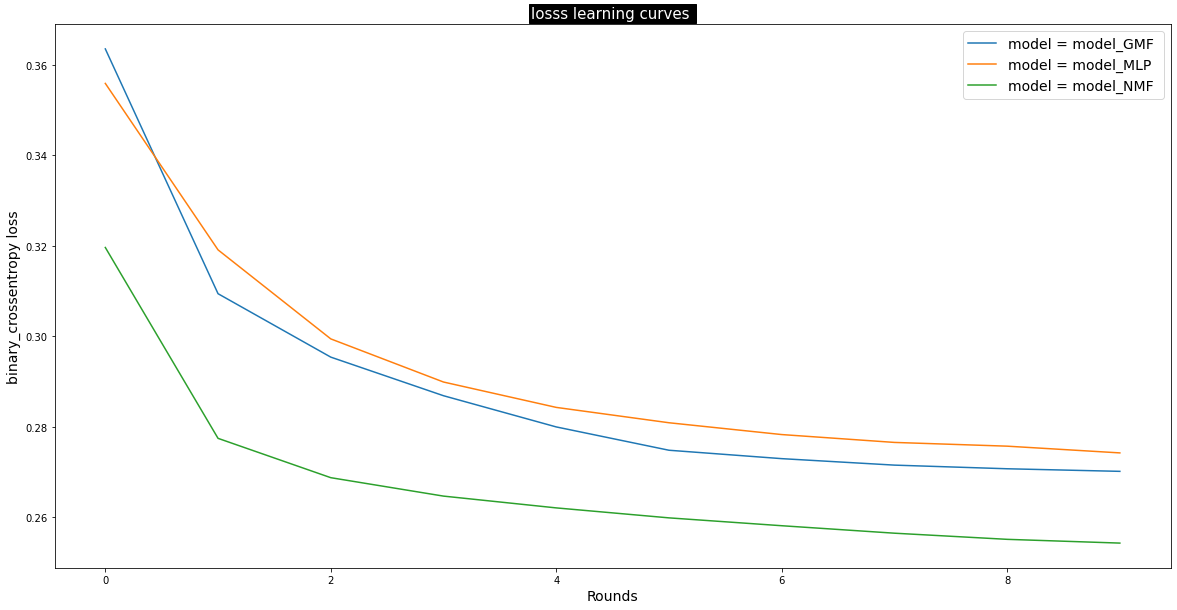

In [78]:
import matplotlib.pyplot as plt 
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title("losss learning curves ",bbox={'facecolor':'k', 'pad':2},color='w',fontsize = 15)
plt.xlabel("Rounds", fontsize=14)
plt.ylabel("binary_crossentropy loss", fontsize=14)
for model, results in models_losses.items():
  print(model)

for model, errors in models_losses.items():
    x = range(len(errors))
    y = errors
    label = 'model = %s ' % model
    plt.errorbar(x,y , label=label)
    plt.legend(loc='upper right', prop={'size': 14})

Following are summary results according to all the different measurements for 3 models.


model_GMF
model_MLP
model_NMF


<Figure size 432x288 with 0 Axes>

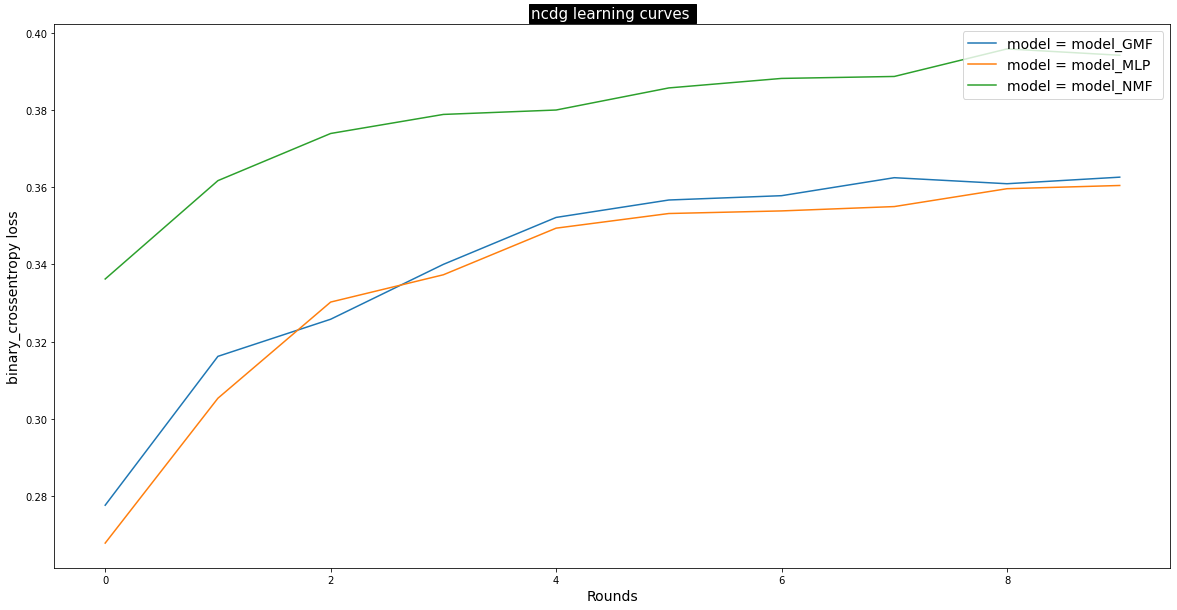

In [82]:
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title("ncdg learning curves ",bbox={'facecolor':'k', 'pad':2},color='w',fontsize = 15)
plt.xlabel("Rounds", fontsize=14)
plt.ylabel("binary_crossentropy loss", fontsize=14)
for model, results in models_losses.items():
  print(model)

for model in models_types:
    x = range(len(errors))
    y = summary_table[summary_table['model_type'] == model]['ncdg_mean']
    label = 'model = %s ' % model
    plt.errorbar(x,y , label=label)
    plt.legend(loc='upper right', prop={'size': 14})

model_GMF
model_MLP
model_NMF


<Figure size 432x288 with 0 Axes>

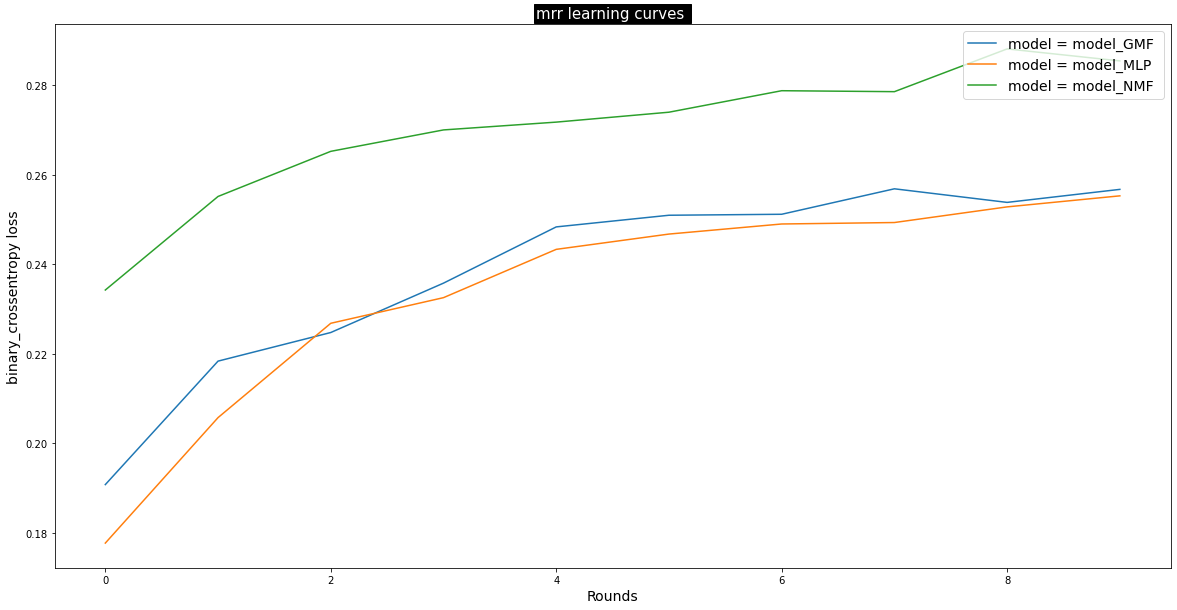

In [84]:
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title("mrr learning curves ",bbox={'facecolor':'k', 'pad':2},color='w',fontsize = 15)
plt.xlabel("Rounds", fontsize=14)
plt.ylabel("binary_crossentropy loss", fontsize=14)
for model, results in models_losses.items():
  print(model)

for model in models_types:
    x = range(len(errors))
    y = summary_table[summary_table['model_type'] == model]['mrr_5_mean']
    label = 'model = %s ' % model
    plt.errorbar(x,y , label=label)
    plt.legend(loc='upper right', prop={'size': 14})

In [81]:
models_types

['model_GMF', 'model_MLP', 'model_NMF']

# my homework

## Question 1 - Data preperation 

1. training.rating - A taining set that consists of user_id, user_item, rating and a timestamp 
2. test.trainig -  test data set , consists of a single point of of rating (the last rating a user gave)  per user. (user_id, item_id, rating, and timestamp).
3. test.negative - a dataset that indicates that a user had an interaction with some movie ( gave a rating, regardless of whether it was high or low rating) and 99 other movies that the user did not interact with . 

In order to create a training dataset that has the same structure as the test.negative which was supplied to us we have the function get_train_instances which is taking a single interaction and a fixed number of random movies (the data is sparse so that we probably wont choose any movies that user had an interaction with).


## Question 2 - Data preperation 

###part A 
Added the following piece of code above
While model_MF was the implementation I added for matrix factorization


Lets see the following learning curves of: loss, ndcg, and mrr for the three models: GMF, MLP, NFM

model_GMF
model_MLP
model_NMF


<Figure size 432x288 with 0 Axes>

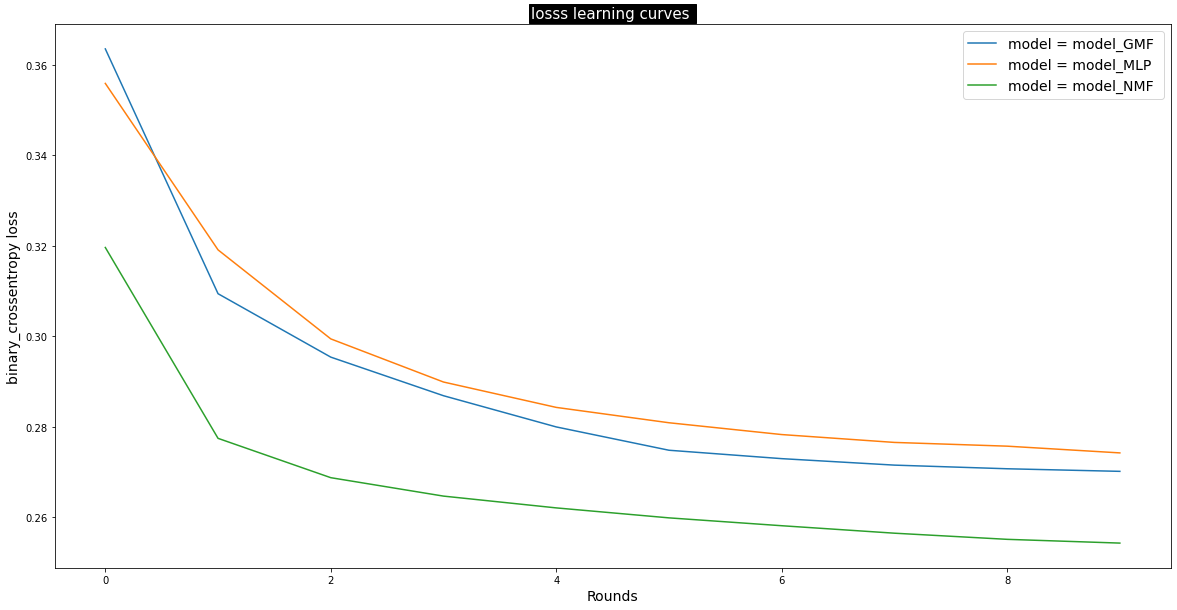

In [86]:
import matplotlib.pyplot as plt 
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title("losss learning curves ",bbox={'facecolor':'k', 'pad':2},color='w',fontsize = 15)
plt.xlabel("Rounds", fontsize=14)
plt.ylabel("binary_crossentropy loss", fontsize=14)
for model, results in models_losses.items():
  print(model)

for model, errors in models_losses.items():
    x = range(len(errors))
    y = errors
    label = 'model = %s ' % model
    plt.errorbar(x,y , label=label)
    plt.legend(loc='upper right', prop={'size': 14})

model_GMF
model_MLP
model_NMF


<Figure size 432x288 with 0 Axes>

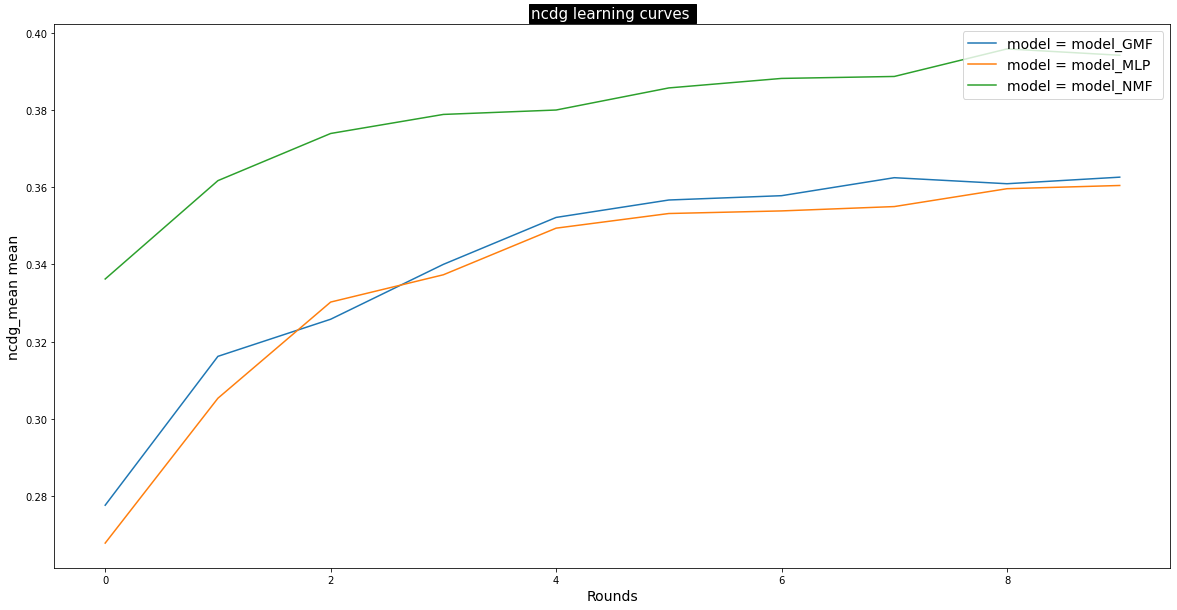

In [89]:
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title("ncdg learning curves ",bbox={'facecolor':'k', 'pad':2},color='w',fontsize = 15)
plt.xlabel("Rounds", fontsize=14)
plt.ylabel("ncdg_mean mean", fontsize=14)
for model, results in models_losses.items():
  print(model)

for model in models_types:
    x = range(len(errors))
    y = summary_table[summary_table['model_type'] == model]['ncdg_mean']
    label = 'model = %s ' % model
    plt.errorbar(x,y , label=label)
    plt.legend(loc='upper right', prop={'size': 14})

model_GMF
model_MLP
model_NMF


<Figure size 432x288 with 0 Axes>

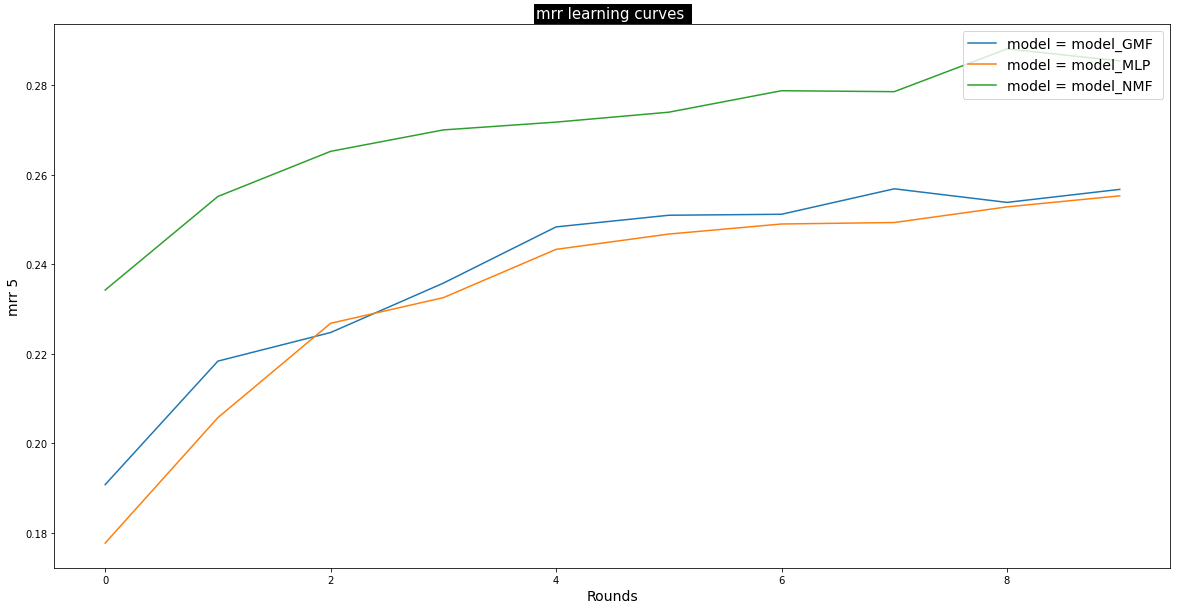

In [90]:
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title("mrr learning curves ",bbox={'facecolor':'k', 'pad':2},color='w',fontsize = 15)
plt.xlabel("Rounds", fontsize=14)
plt.ylabel("mrr 5", fontsize=14)
for model, results in models_losses.items():
  print(model)

for model in models_types:
    x = range(len(errors))
    y = summary_table[summary_table['model_type'] == model]['mrr_5_mean']
    label = 'model = %s ' % model
    plt.errorbar(x,y , label=label)
    plt.legend(loc='upper right', prop={'size': 14})

model_GMF
model_MLP
model_NMF


<Figure size 432x288 with 0 Axes>

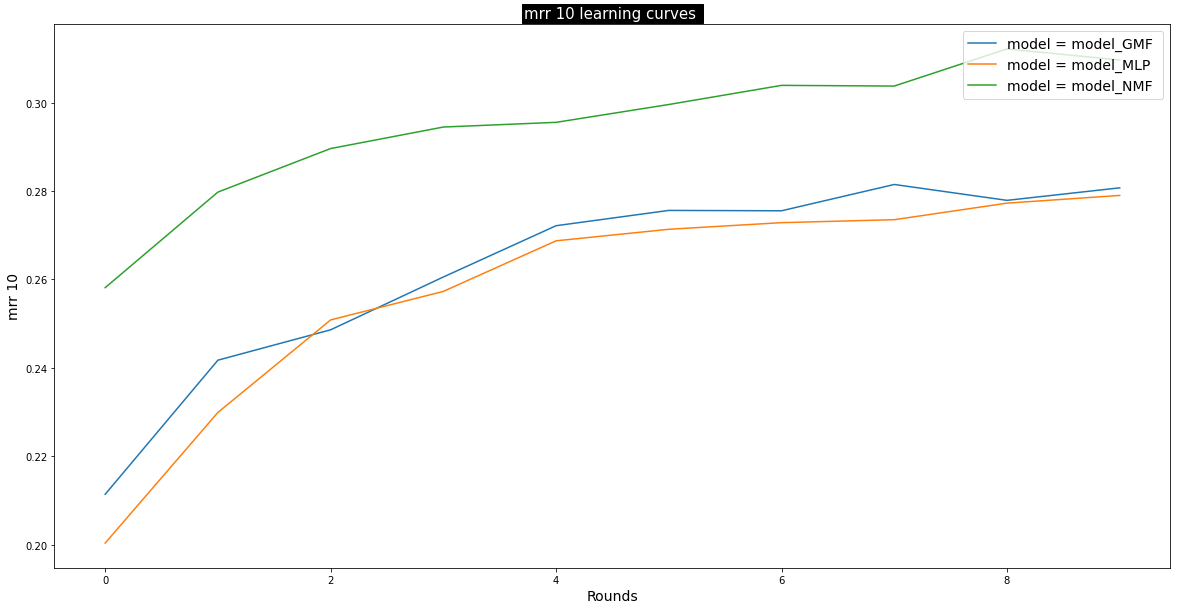

In [91]:
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title("mrr 10 learning curves ",bbox={'facecolor':'k', 'pad':2},color='w',fontsize = 15)
plt.xlabel("Rounds", fontsize=14)
plt.ylabel("mrr 10", fontsize=14)
for model, results in models_losses.items():
  print(model)

for model in models_types:
    x = range(len(errors))
    y = summary_table[summary_table['model_type'] == model]['mrr_10_mean']
    label = 'model = %s ' % model
    plt.errorbar(x,y , label=label)
    plt.legend(loc='upper right', prop={'size': 14})

We can see that for the 4 different evaluation methods NMF is always better with the following results: 
 

In [112]:
summary_table[ summary_table['epoch'] == 9]


,model_type,loss,hit_rate_mean,ncdg_mean,loss,mrr_5_mean,mrr_10_mean,epoch
8,model_GMF,0.270688,0.631623,0.360863,0.270688,0.253844,0.277892,9
18,model_MLP,0.275681,0.628146,0.359575,0.275681,0.252839,0.277261,9
28,model_NMF,0.255094,0.667881,0.395754,0.255094,0.288137,0.312135,9


These are not very suprising results, since we know that the Neural Matrix Factorization is a stronger model. 
In homework2 and homework1, we also had a few stronger models, but their strength was not reflected in the results. I suspect it is due to lack of data. 
This time the size of the data is 100 times bigger, so it allows a more complex model like the neural matrix factorization to shine. 

## Part B

The results of MRR and NDCG are much much lower  (2-3 times lower) in this method than in previous homeworks. But it is also no a very fair / clean comparison. 
In the previous homework we were working with explicit ranking and very differnt data preperations:  


1. The evauluation and data preperation is very different. In HW1 and HW2 we evaluated only the movies that the user interacted with: i.e rated. and then we sorted according to prediction and produced the ndcg and mrr results. In this model we are taking the latest movie the user interacted with, regardless of how much he liked the movie, and 99 random movies. The baseline MRR for that is very low (just 5% chance for random correctness). this kind of data preperation also yields very different results. 
2. In the previous HW we took into account the user actual rating and tried to predict the user new rating. In this excercise we are only taking into consideration the user interaction and not the actual rating. This may result in a model that does not understands the user taste in the same manner, and thus has less power to predict movies that the user did not interact with. 




## Part C

In the NeuMF model the latent user and item matrix factorization may be used to find item and user similarity. 
A good way to measure similarity would be to use cosine similiarity, some other kind of correlation between the item or users vectors. 
That way we can find users with similar tast , or items that would be liked by similar users just by using the implicit interactions of users and items . 

## Question 3


In [116]:
model_NMF_Q3 = get_NMF_model_question3(num_users, num_items, latent_dim_GMF=num_factors, latent_dim_MLP=num_factors, reg_GMF=[[0,0]],
                      regs_MLP=[[0,0],0,0,0], layers=[32,16,8])
models = {'model_NMF_Q3': model_NMF_Q3 }


In [121]:
models_types = ['model_NMF_Q3']

best_hr, best_ndcg, best_iter, best_mrr_5, best_mrr_10 = -1,-1, -1, -1, -1

results_for_all_models = []
for model_type in models_types:
  model = models[model_type]
  epochs_results = []
  for epoch in range(10):
      t1 = time()
      # Generate training instances
      user_input, item_input, labels = get_train_instances(train, num_negatives)

      # Training
      hist = model.fit([np.array(user_input), np.array(item_input)], #input
                      np.array(labels), # labels 
                      batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
      t2 = time()

      # Evaluation
      print('epoch: ', epoch)
      if epoch %verbose == 0:
          print('evaluating epoch: ', epoch)
          (hits, ndcgs, mrrs_5, mrrs_10) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
          hr, ndcg, mrr_5, mrr_10, loss = np.array(hits).mean(), np.array(ndcgs).mean(), np.array(mrrs_5).mean(), np.array(mrrs_10).mean(), hist.history['loss'][0]
          epochs_results.append({'hits': hits, 'ndcgs': ndcgs, 'mrrs_5': mrrs_5, 'mrrs_10': mrrs_10, 'loss': loss})
          print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f,  MRR_5 = %.4f, MRR_10 = %.4f, loss = %.4f [%.1f s]' 
                % (epoch,  t2-t1, hr, ndcg,mrr_5, mrr_10, loss, time()-t2))
          if hr > best_hr:
              best_hr, best_ndcg, best_iter, best_mrr_5, best_mrr_10 = hr, ndcg, epoch, mrr_5, mrr_10
              if write_model:
                  model.save_weights(model_out_file, overwrite=True)
  results_for_all_models.append({'model_type': model_type, 'epochs_results': epochs_results})

  print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))
  if write_model:
      print("The best GMF model is saved to %s" %(model_out_file))

epoch:  0
evaluating epoch:  0
Iteration 0 [58.1 s]: HR = 0.6245, NDCG = 0.3600,  MRR_5 = 0.2556, MRR_10 = 0.2787, loss = 0.0873 [239.6 s]
epoch:  1
evaluating epoch:  1
Iteration 1 [58.0 s]: HR = 0.6348, NDCG = 0.3673,  MRR_5 = 0.2614, MRR_10 = 0.2852, loss = 0.0850 [240.3 s]
epoch:  2
evaluating epoch:  2
Iteration 2 [59.0 s]: HR = 0.6492, NDCG = 0.3753,  MRR_5 = 0.2669, MRR_10 = 0.2912, loss = 0.0838 [243.9 s]
epoch:  3
evaluating epoch:  3
Iteration 3 [58.9 s]: HR = 0.6460, NDCG = 0.3743,  MRR_5 = 0.2670, MRR_10 = 0.2908, loss = 0.0829 [244.2 s]
epoch:  4
evaluating epoch:  4
Iteration 4 [58.5 s]: HR = 0.6518, NDCG = 0.3809,  MRR_5 = 0.2738, MRR_10 = 0.2977, loss = 0.0822 [243.8 s]
epoch:  5
evaluating epoch:  5
Iteration 5 [58.7 s]: HR = 0.6599, NDCG = 0.3842,  MRR_5 = 0.2753, MRR_10 = 0.2994, loss = 0.0816 [245.9 s]
epoch:  6
evaluating epoch:  6
Iteration 6 [59.5 s]: HR = 0.6619, NDCG = 0.3846,  MRR_5 = 0.2752, MRR_10 = 0.2993, loss = 0.0810 [242.4 s]
epoch:  7
evaluating epoch:

In [127]:
models_losses = {}
for m in models_types:
  models_losses[m] = []

summary_table2 = pd.DataFrame(columns=['model_type', 'loss','hit_rate_mean', 'ncdg_mean','loss', 'mrr_5_mean', 'mrr_10_mean', 'epoch' ])

for model_result in results_for_all_models:
  last_round = model_result['epochs_results'][-1]
  for idx, epoch_res in enumerate(model_result['epochs_results']):
    models_losses[model_result['model_type']].append(epoch_res['loss'])
    row = {
      'model_type': model_result['model_type'],
      'loss':  epoch_res['loss'],
      'hit_rate_mean': np.array(epoch_res['hits']).mean(),
      'ncdg_mean': np.array(epoch_res['ndcgs']).mean(),
      'mrr_5_mean': np.array(epoch_res['mrrs_5']).mean(),
      'mrr_10_mean': np.array(epoch_res['mrrs_10']).mean(),
      'epoch': idx + 1} 
    summary_table2 = summary_table2.append(row, ignore_index=True)
    # print(row)


# model_out_file = path + 'summary_table.csv')
summary_table2.to_csv(path + 'summary_table2.csv')

In [128]:
summary_table2

,model_type,loss,hit_rate_mean,ncdg_mean,loss,mrr_5_mean,mrr_10_mean,epoch
0,model_NMF_Q3,0.087263,0.624503,0.360004,0.087263,0.255626,0.278750,1
1,model_NMF_Q3,0.085001,0.634768,0.367335,0.085001,0.261418,0.285247,2
2,model_NMF_Q3,0.083779,0.649172,0.375318,0.083779,0.266887,0.291172,3
3,model_NMF_Q3,0.082904,0.646026,0.374297,0.082904,0.267039,0.290770,4
4,model_NMF_Q3,0.082182,0.651821,0.380879,0.082182,0.273786,0.297715,5
5,model_NMF_Q3,0.081599,0.659934,0.384244,0.081599,0.275339,0.299378,6
6,model_NMF_Q3,0.081038,0.661921,0.384588,0.081038,0.275221,0.299326,7
7,model_NMF_Q3,0.080546,0.665066,0.386686,0.080546,0.277058,0.301152,8
8,model_NMF_Q3,0.080232,0.658775,0.386903,0.080232,0.279644,0.303250,9
9,model_NMF_Q3,0.079799,0.663576,0.390542,0.079799,0.282925,0.306447,10


We can see that the loss if far smaller with this loss function methods, though the MRR did not change so much .
Lets first see all the learning curves, and then compare it with previous models. 


<Figure size 432x288 with 0 Axes>

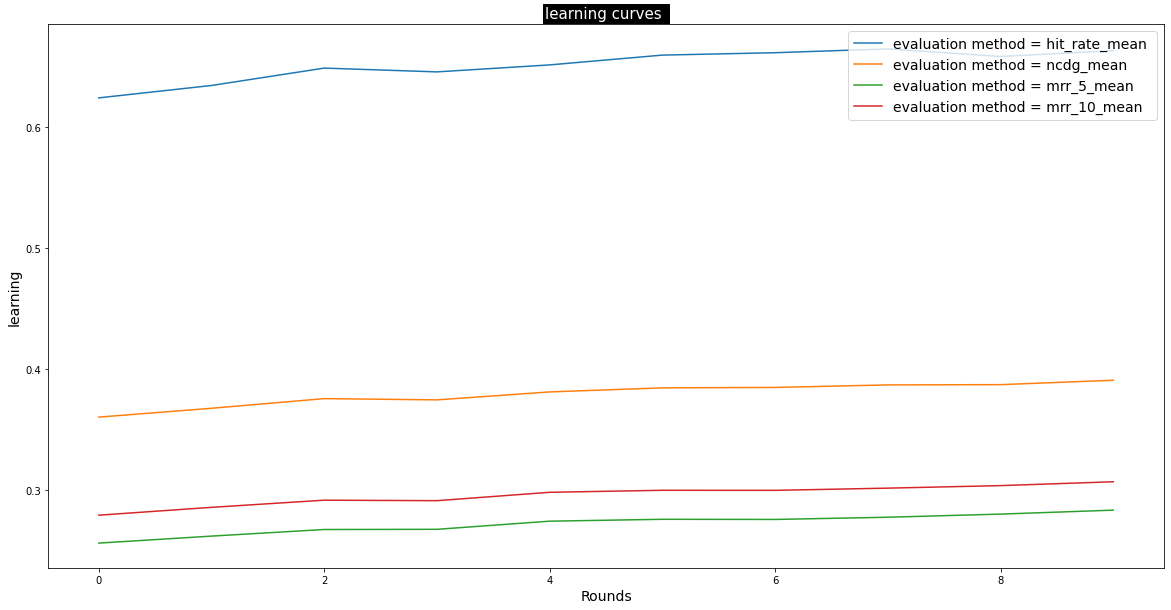

In [149]:
fig = plt.figure()
plt.figure(figsize=(20,10))
plt.title("learning curves ",bbox={'facecolor':'k', 'pad':2},color='w',fontsize = 15)
plt.xlabel("Rounds", fontsize=14)
plt.ylabel("learning", fontsize=14)


for col in ['hit_rate_mean', 'ncdg_mean', 'mrr_5_mean', 'mrr_10_mean']:
    x = range(len(summary_table2[col]))
    y = summary_table2[col]
    label = 'evaluation method = %s ' % col
    plt.errorbar(x,y , label=label)
    plt.legend(loc='upper right', prop={'size': 14})

In [153]:
summary_table[ summary_table['epoch'] == 9]

,model_type,loss,hit_rate_mean,ncdg_mean,loss,mrr_5_mean,mrr_10_mean,epoch
8,model_GMF,0.270688,0.631623,0.360863,0.270688,0.253844,0.277892,9
18,model_MLP,0.275681,0.628146,0.359575,0.275681,0.252839,0.277261,9
28,model_NMF,0.255094,0.667881,0.395754,0.255094,0.288137,0.312135,9


In [154]:
summary_table2[ summary_table2['epoch'] == 9]

,model_type,loss1,hit_rate_mean,ncdg_mean,loss2,mrr_5_mean,mrr_10_mean,epoch
8,model_NMF_Q3,0.080232,0.658775,0.386903,0.080232,0.279644,0.30325,9


We can see that the model from the articel: model_NMF_Q3 performance is very similar to the one from the previous section: model_NMF by all evaluation ,methods. 